# Menghubungkan Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import random
import cv2
import os
import shutil
import glob as gb
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Image
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.metrics import Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler

# Memuat Data

In [ ]:
image_dir = Path('/content/drive/MyDrive/pink eye goat classification/dataset')

# Mendapatkan path file dan label
filepaths = list(image_dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

file_extensions = set(path.suffix.lower() for path in filepaths)
print("Ekstensi File yang Ditemukan:", file_extensions)

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

# Menggabungkan path file dengan label
images_df = pd.concat([filepaths, labels], axis=1)

# Acak data dan reset index
images_df = images_df.sample(frac=1).reset_index(drop=True)

# Menampilkan data
images_df.head()

Ekstensi File yang Ditemukan: {'.png', '.jpg'}


,Filepaths,Labels
0,/content/drive/MyDrive/pink eye goat classific...,pinkeye
1,/content/drive/MyDrive/pink eye goat classific...,sehat
2,/content/drive/MyDrive/pink eye goat classific...,pinkeye
3,/content/drive/MyDrive/pink eye goat classific...,sehat
4,/content/drive/MyDrive/pink eye goat classific...,sehat


In [ ]:
images_df.Labels.value_counts()

Labels
pinkeye    69
sehat      47
Name: count, dtype: int64

Visualisasi

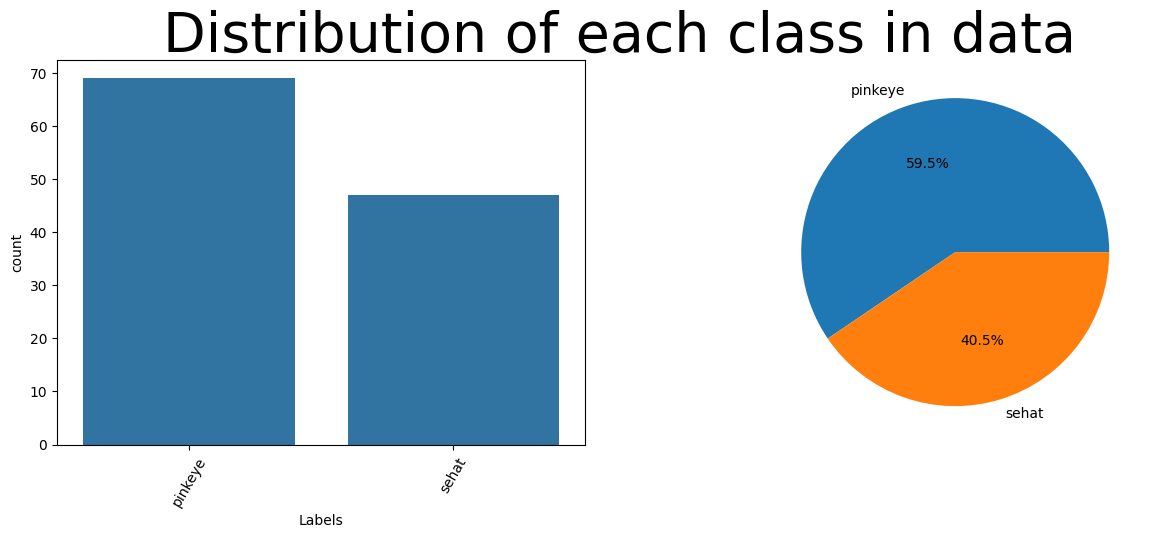

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=images_df,x='Labels')
plt.xticks(rotation = 60)
plt.subplot(1,2,2)
plt.pie(x = images_df['Labels'].value_counts().values, labels=images_df['Labels'].value_counts().index,autopct='%1.1f%%')
plt.suptitle('Distribution of each class in data',size=40)
plt.show()

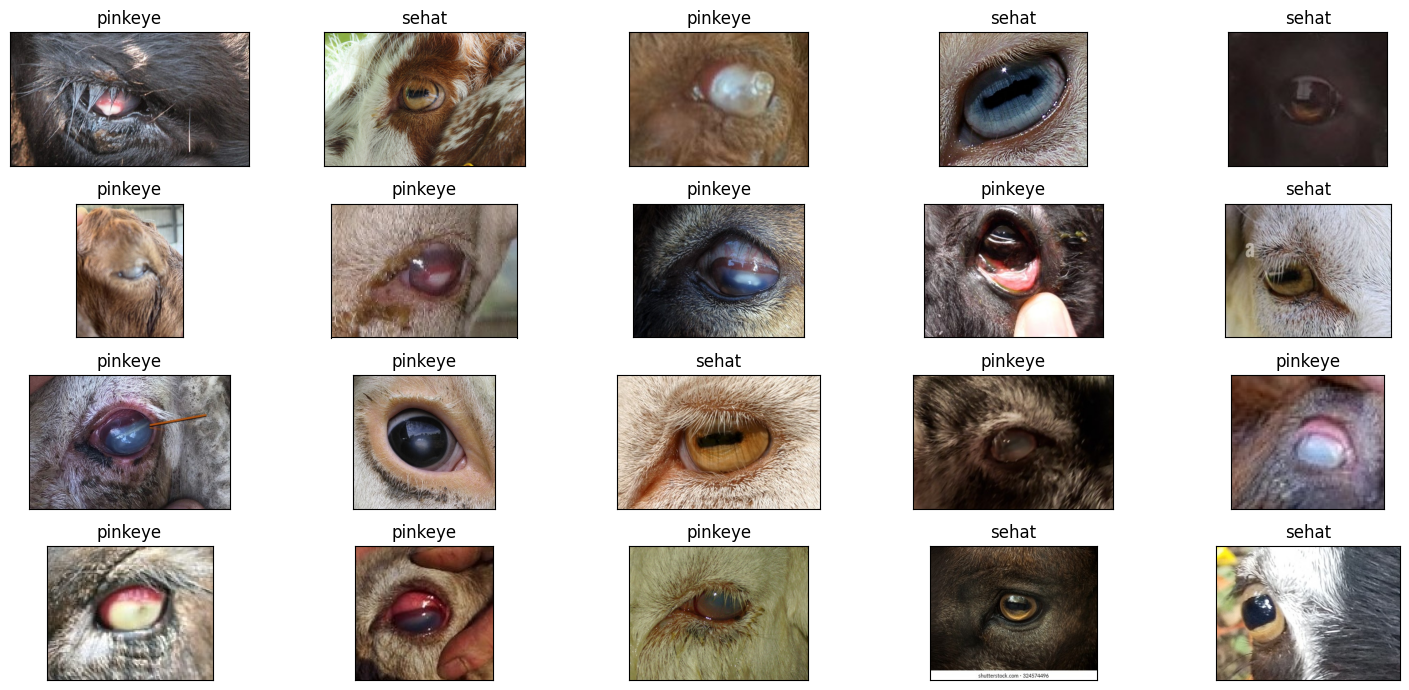

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_df.Filepaths[i]))
    ax.set_title(images_df.Labels[i])
plt.tight_layout()
plt.show()

Pembagian data

In [ ]:
train_df, test_df = train_test_split(images_df, test_size=0.2, random_state=2, shuffle=True, stratify=images_df['Labels'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=2, shuffle=True, stratify=test_df['Labels'])

In [ ]:
train_df.count()

Filepaths    92
Labels       92
dtype: int64

In [ ]:
val_df.count()

Filepaths    12
Labels       12
dtype: int64

In [ ]:
test_df.count()

Filepaths    12
Labels       12
dtype: int64

# Preprocessing Data

In [ ]:
# Tetapkan seed acak
seed_value = 2
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)
tf.config.experimental.enable_op_determinism()

In [ ]:
# ImageDataGenerator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator untuk data validasi tanpa augmentasi
val_datagen = ImageDataGenerator()

# ImageDataGenerator untuk data pengujian tanpa augmentasi
test_datagen = ImageDataGenerator()

# Flow from DataFrame untuk data pelatihan
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=5,
    shuffle=True
)

# Flow from DataFrame untuk data validasi
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=2,
    shuffle=False
)

# Flow from DataFrame untuk data pengujian
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=,
    shuffle=False
)

Found 92 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'pinkeye': 0, 'sehat': 1}

# Pelatihan Model berbasis CNN

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [ ]:
optimizer = optimizers.RMSprop(learning_rate=0.001)

In [ ]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator,validation_data=val_generator, epochs=epoch, verbose=1, callbacks=callback)

Epoch 1/10
19/19 [==============================] - 49s 3s/step - loss: 159.3607 - accuracy: 0.6413 - val_loss: 1.5941 - val_accuracy: 0.5833
Epoch 2/10
19/19 [==============================] - 17s 902ms/step - loss: 1.6815 - accuracy: 0.6304 - val_loss: 1.2393 - val_accuracy: 0.5833
Epoch 3/10
19/19 [==============================] - 17s 912ms/step - loss: 0.9460 - accuracy: 0.6087 - val_loss: 0.7938 - val_accuracy: 0.5833
Epoch 4/10
19/19 [==============================] - 17s 890ms/step - loss: 8.5900 - accuracy: 0.5761 - val_loss: 19.3895 - val_accuracy: 0.5833
Epoch 5/10
19/19 [==============================] - 17s 890ms/step - loss: 3.0851 - accuracy: 0.5652 - val_loss: 0.7342 - val_accuracy: 0.5000
Epoch 6/10
19/19 [==============================] - 19s 986ms/step - loss: 0.7893 - accuracy: 0.6630 - val_loss: 0.6107 - val_accuracy: 0.5833
Epoch 7/10
19/19 [==============================] - 17s 882ms/step - loss: 0.8048 - accuracy: 0.6413 - val_loss: 0.6971 - val_accuracy: 0.5833

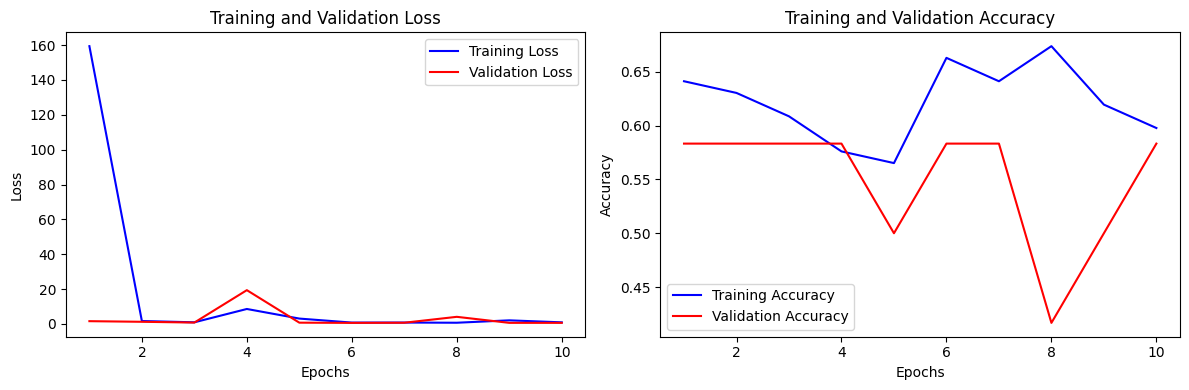

In [ ]:
# Mengambil data dari history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Testing**

In [ ]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)

labels = train_generator.class_indices
labels = dict((v,k) for k, v in labels.items())

print(labels)
print(pred)

12/12 [==============================] - 4s 352ms/step
{0: 'pinkeye', 1: 'sehat'}
[0 0 0 1 0 1 0 0 0 1 1 0]


In [ ]:
print(classification_report(test_generator.classes, pred, target_names=['pinkeye', 'sehat']))
print('--------------------------------')
print(confusion_matrix(test_generator.classes, pred))
print('--------------------------------')
# Extracting F1-score, recall, precision, and accuracy
f1_value = f1_score(test_generator.classes, pred, average='weighted')
recall = recall_score(test_generator.classes, pred, average='weighted')
precision = precision_score(test_generator.classes, pred, average='weighted')
accuracy = accuracy_score(test_generator.classes, pred)


# Print with four decimal places
print(f'F1 Score: {round(f1_value, 4)}')
print(f'Recall: {round(recall, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'Accuracy: {round(accuracy, 4)}')

              precision    recall  f1-score   support

     pinkeye       0.62      0.71      0.67         7
       sehat       0.50      0.40      0.44         5

    accuracy                           0.58        12
   macro avg       0.56      0.56      0.56        12
weighted avg       0.57      0.58      0.57        12

--------------------------------
[[5 2]
 [3 2]]
--------------------------------
F1 Score: 0.5741
Recall: 0.5833
Precision: 0.5729
Accuracy: 0.5833


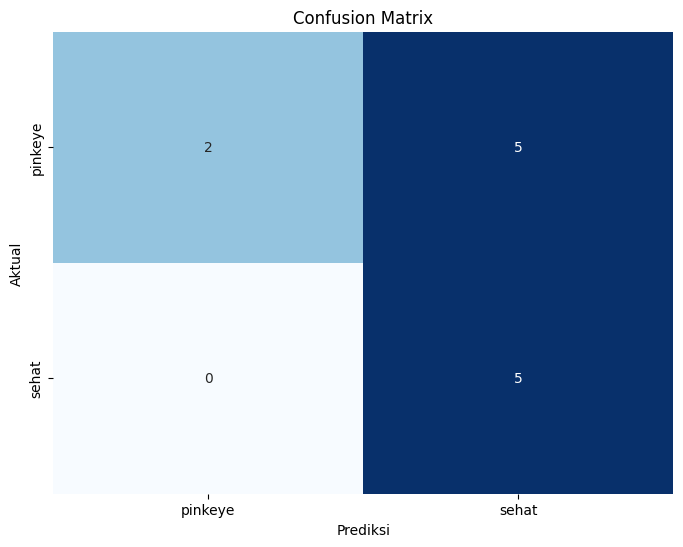

In [ ]:
cm = confusion_matrix(test_generator.classes, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['pinkeye', 'sehat'],
            yticklabels=['pinkeye', 'sehat'])
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

**Simpan Model**

In [ ]:
%cd /content/drive/MyDrive/pink eye goat classification

/content/drive/MyDrive/pink eye goat classification


In [ ]:
# Tentukan nama file untuk menyimpan model H5
model_filename = 'cnn_model.h5'

# Simpan model ke dalam file H5
model.save(model_filename)

print(f"Model telah disimpan dalam file: {model_filename}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model telah disimpan dalam file: cnn_model.h5


# Pelatihan Model berbasis VGG16 Tanpa Transfer Learning

In [ ]:
def VGG16():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(2, activation='sigmoid'))
    return model

model = VGG16()

In [ ]:
optimizer = optimizers.RMSprop(learning_rate=0.001)

In [ ]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator,validation_data=val_generator, epochs=epoch, verbose=1, callbacks=callback)

Epoch 1/10
19/19 [==============================] - 9s 310ms/step - loss: 38990.9180 - accuracy: 0.5326 - val_loss: 0.6931 - val_accuracy: 0.5833
Epoch 2/10
19/19 [==============================] - 4s 230ms/step - loss: 0.6925 - accuracy: 0.5435 - val_loss: 0.6918 - val_accuracy: 0.5833
Epoch 3/10
19/19 [==============================] - 4s 230ms/step - loss: 0.6907 - accuracy: 0.5978 - val_loss: 0.6898 - val_accuracy: 0.5833
Epoch 4/10
19/19 [==============================] - 5s 240ms/step - loss: 0.6885 - accuracy: 0.5978 - val_loss: 0.6874 - val_accuracy: 0.5833
Epoch 5/10
19/19 [==============================] - 5s 269ms/step - loss: 0.6863 - accuracy: 0.5978 - val_loss: 0.6857 - val_accuracy: 0.5833
Epoch 6/10
19/19 [==============================] - 5s 290ms/step - loss: 0.6836 - accuracy: 0.5978 - val_loss: 0.6824 - val_accuracy: 0.5833
Epoch 7/10
19/19 [==============================] - 4s 231ms/step - loss: 0.6809 - accuracy: 0.5978 - val_loss: 0.6799 - val_accuracy: 0.5833
Ep

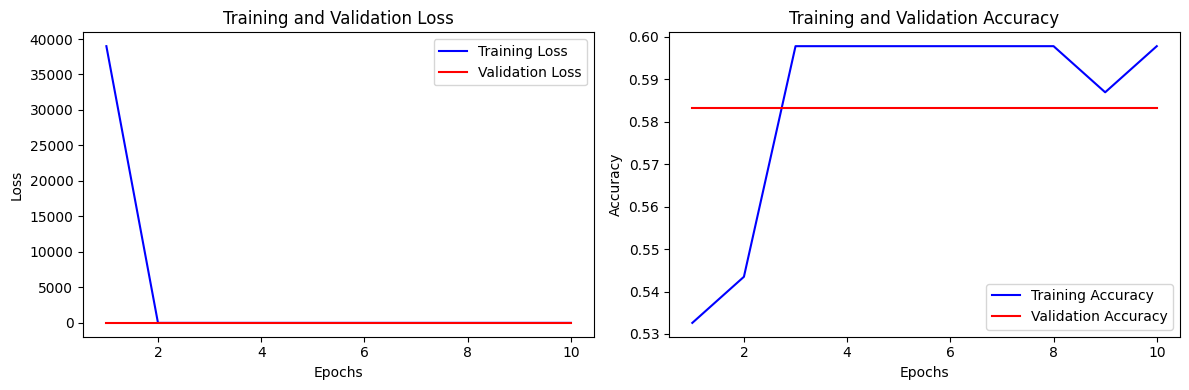

In [ ]:
# Mengambil data dari history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Testing**

In [ ]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)

labels = train_generator.class_indices
labels = dict((v,k) for k, v in labels.items())

print(labels)
print(pred)

12/12 [==============================] - 1s 24ms/step
{0: 'pinkeye', 1: 'sehat'}
[0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(classification_report(test_generator.classes, pred, target_names=['pinkeye', 'sehat']))
print('--------------------------------')
print(confusion_matrix(test_generator.classes, pred))
print('--------------------------------')
# Extracting F1-score, recall, precision, and accuracy
f1_value = f1_score(test_generator.classes, pred, average='weighted')
recall = recall_score(test_generator.classes, pred, average='weighted')
precision = precision_score(test_generator.classes, pred, average='weighted')
accuracy = accuracy_score(test_generator.classes, pred)


# Print with four decimal places
print(f'F1 Score: {round(f1_value, 4)}')
print(f'Recall: {round(recall, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'Accuracy: {round(accuracy, 4)}')

              precision    recall  f1-score   support

     pinkeye       0.58      1.00      0.74         7
       sehat       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

--------------------------------
[[7 0]
 [5 0]]
--------------------------------
F1 Score: 0.4298
Recall: 0.5833
Precision: 0.3403
Accuracy: 0.5833


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

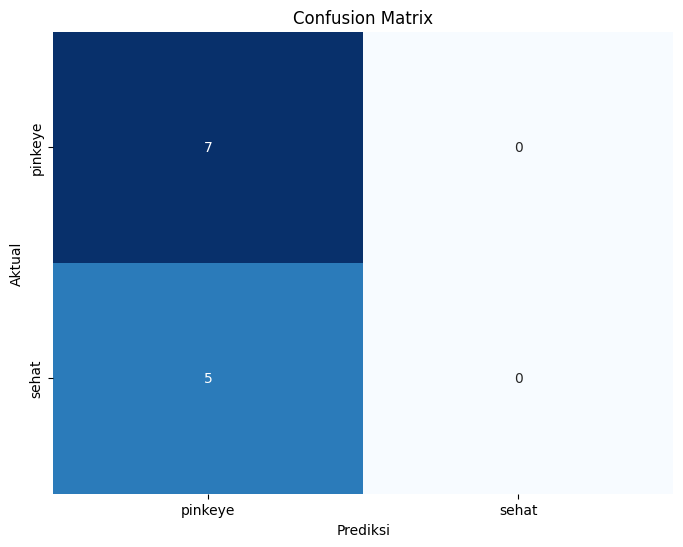

In [ ]:
cm = confusion_matrix(test_generator.classes, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['pinkeye', 'sehat'],
            yticklabels=['pinkeye', 'sehat'])
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

**Simpan Model**

In [ ]:
%cd /content/drive/MyDrive/pink eye goat classification

/content/drive/MyDrive/pink eye goat classification


In [ ]:
# Tentukan nama file untuk menyimpan model H5
model_filename = 'vgg16_model.h5'

# Simpan model ke dalam file H5
model.save(model_filename)

print(f"Model telah disimpan dalam file: {model_filename}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model telah disimpan dalam file: vgg16_model.h5


# Pelatihan Model berbasis VGG16 Transfer Learning

In [ ]:
from tensorflow.keras.applications import VGG16

# Membuat model VGG16 tanpa lapisan teratas (top layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membuat model Sequential baru untuk menambahkan lapisan-lapisan kustom
model = Sequential()

# Menambahkan lapisan-lapisan VGG16 ke dalam model baru
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # jumlah kelas, sesuaikan dengan jumlah kelas Anda

# Mematikan pelatihan lapisan-lapisan VGG16 yang sudah dilatih
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = optimizers.RMSprop(learning_rate=0.001)

In [ ]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator,validation_data=val_generator, epochs=epoch, verbose=1, callbacks=callback)

Epoch 1/10
19/19 [==============================] - 4s 161ms/step - loss: 50.1148 - accuracy: 0.5217 - val_loss: 9.7676 - val_accuracy: 0.7500
Epoch 2/10
19/19 [==============================] - 3s 137ms/step - loss: 5.3137 - accuracy: 0.7283 - val_loss: 16.9704 - val_accuracy: 0.5833
Epoch 3/10
19/19 [==============================] - 3s 144ms/step - loss: 7.4198 - accuracy: 0.6848 - val_loss: 5.9783 - val_accuracy: 0.7500
Epoch 4/10
19/19 [==============================] - 5s 261ms/step - loss: 1.2470 - accuracy: 0.8913 - val_loss: 2.6043 - val_accuracy: 0.7500
Epoch 5/10
19/19 [==============================] - 5s 245ms/step - loss: 2.9038 - accuracy: 0.8043 - val_loss: 0.7946 - val_accuracy: 0.8333
Epoch 6/10
19/19 [==============================] - 3s 148ms/step - loss: 1.6105 - accuracy: 0.8913 - val_loss: 1.6661 - val_accuracy: 0.7500
Epoch 7/10
19/19 [==============================] - 3s 182ms/step - loss: 1.6213 - accuracy: 0.8587 - val_loss: 1.1437 - val_accuracy: 0.9167
Epoc

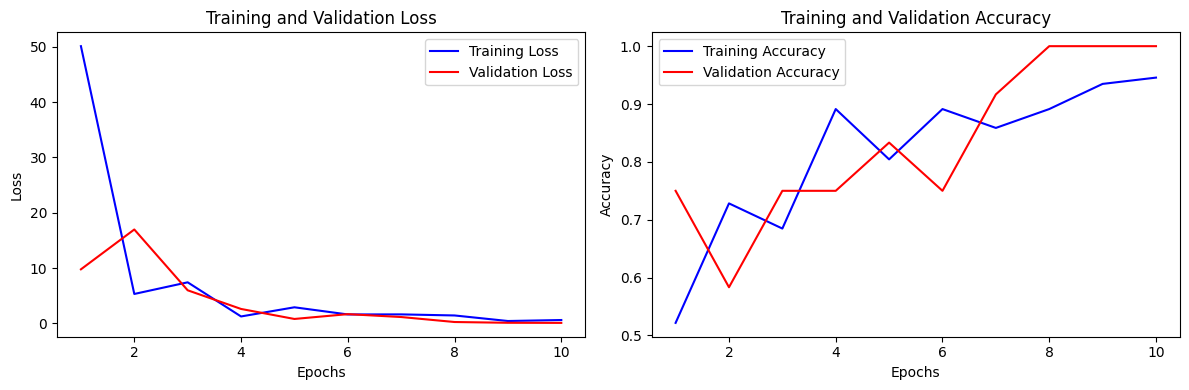

In [ ]:
# Mengambil data dari history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Testing**

In [ ]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)

labels = train_generator.class_indices
labels = dict((v,k) for k, v in labels.items())

print(labels)
print(pred)

12/12 [==============================] - 0s 18ms/step
{0: 'pinkeye', 1: 'sehat'}
[1 0 1 1 1 0 1 1 0 1 0 0]


In [ ]:
print(classification_report(test_generator.classes, pred, target_names=['pinkeye', 'sehat']))
print('--------------------------------')
print(confusion_matrix(test_generator.classes, pred))
print('--------------------------------')
# Extracting F1-score, recall, precision, and accuracy
f1_value = f1_score(test_generator.classes, pred, average='weighted')
recall = recall_score(test_generator.classes, pred, average='weighted')
precision = precision_score(test_generator.classes, pred, average='weighted')
accuracy = accuracy_score(test_generator.classes, pred)


# Print with four decimal places
print(f'F1 Score: {round(f1_value, 4)}')
print(f'Recall: {round(recall, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'Accuracy: {round(accuracy, 4)}')

              precision    recall  f1-score   support

     pinkeye       1.00      0.71      0.83         7
       sehat       0.71      1.00      0.83         5

    accuracy                           0.83        12
   macro avg       0.86      0.86      0.83        12
weighted avg       0.88      0.83      0.83        12

--------------------------------
[[5 2]
 [0 5]]
--------------------------------
F1 Score: 0.8333
Recall: 0.8333
Precision: 0.881
Accuracy: 0.8333


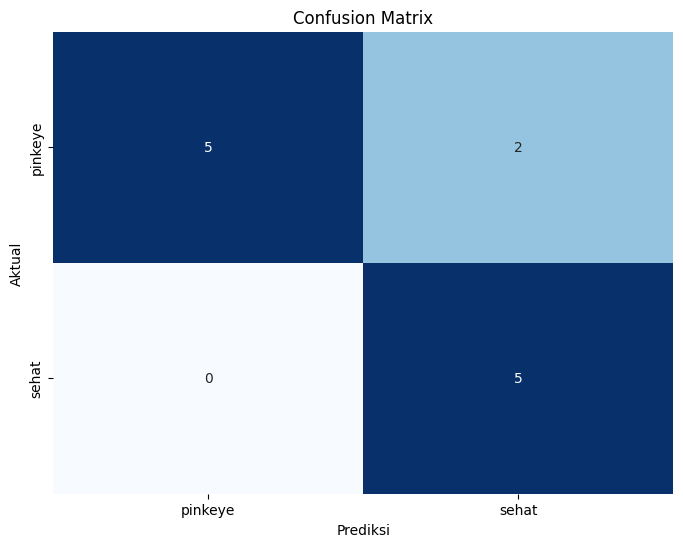

In [ ]:
cm = confusion_matrix(test_generator.classes, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['pinkeye', 'sehat'],
            yticklabels=['pinkeye', 'sehat'])
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

**Simpan Model**

In [ ]:
%cd /content/drive/MyDrive/pink eye goat classification

/content/drive/MyDrive/pink eye goat classification


In [ ]:
# Tentukan nama file untuk menyimpan model H5
model_filename = 'vgg16_transfer_model.h5'

# Simpan model ke dalam file H5
model.save(model_filename)

print(f"Model telah disimpan dalam file: {model_filename}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model telah disimpan dalam file: vgg16_transfer_model.h5


# Pelatihan Model berbasis VGG16 Transfer Learning + Dropout

In [ ]:
from tensorflow.keras.applications import VGG16

# Membuat model VGG16 tanpa lapisan teratas (top layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membuat model Sequential baru untuk menambahkan lapisan-lapisan kustom
model = Sequential()

# Menambahkan lapisan-lapisan VGG16 ke dalam model baru
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # jumlah kelas, sesuaikan dengan jumlah kelas Anda

# Mematikan pelatihan lapisan-lapisan VGG16 yang sudah dilatih
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = optimizers.RMSprop(learning_rate=0.001)

In [ ]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator,validation_data=val_generator, epochs=epoch, verbose=1, callbacks=callback)

Epoch 1/10
19/19 [==============================] - 4s 159ms/step - loss: 35.1182 - accuracy: 0.5435 - val_loss: 14.0018 - val_accuracy: 0.5833
Epoch 2/10
19/19 [==============================] - 3s 135ms/step - loss: 8.1583 - accuracy: 0.6957 - val_loss: 10.3032 - val_accuracy: 0.6667
Epoch 3/10
19/19 [==============================] - 3s 134ms/step - loss: 4.2858 - accuracy: 0.7500 - val_loss: 7.3637 - val_accuracy: 0.7500
Epoch 4/10
19/19 [==============================] - 3s 159ms/step - loss: 4.3913 - accuracy: 0.7717 - val_loss: 13.6636 - val_accuracy: 0.5000
Epoch 5/10
19/19 [==============================] - 3s 161ms/step - loss: 3.0186 - accuracy: 0.8696 - val_loss: 3.7105 - val_accuracy: 0.7500
Epoch 6/10
19/19 [==============================] - 3s 135ms/step - loss: 5.0051 - accuracy: 0.8043 - val_loss: 3.6548 - val_accuracy: 0.8333
Epoch 7/10
19/19 [==============================] - 3s 135ms/step - loss: 3.2570 - accuracy: 0.8261 - val_loss: 4.6859 - val_accuracy: 0.8333
Ep

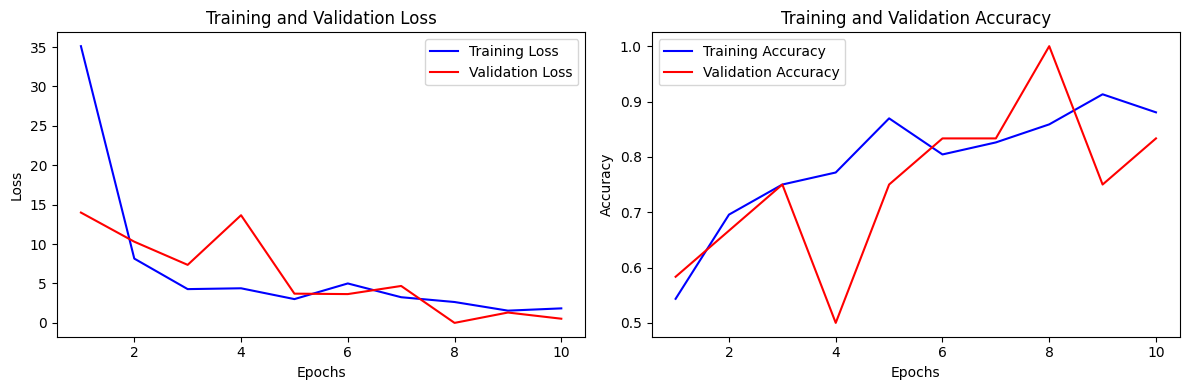

In [ ]:
# Mengambil data dari history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Testing**

In [ ]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)

labels = train_generator.class_indices
labels = dict((v,k) for k, v in labels.items())

print(labels)
print(pred)

12/12 [==============================] - 0s 21ms/step
{0: 'pinkeye', 1: 'sehat'}
[0 0 1 1 1 0 0 1 0 1 0 0]


In [ ]:
print(classification_report(test_generator.classes, pred, target_names=['pinkeye', 'sehat']))
print('--------------------------------')
print(confusion_matrix(test_generator.classes, pred))
print('--------------------------------')
# Extracting F1-score, recall, precision, and accuracy
f1_value = f1_score(test_generator.classes, pred, average='weighted')
recall = recall_score(test_generator.classes, pred, average='weighted')
precision = precision_score(test_generator.classes, pred, average='weighted')
accuracy = accuracy_score(test_generator.classes, pred)


# Print with four decimal places
print(f'F1 Score: {round(f1_value, 4)}')
print(f'Recall: {round(recall, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'Accuracy: {round(accuracy, 4)}')

              precision    recall  f1-score   support

     pinkeye       1.00      1.00      1.00         7
       sehat       1.00      1.00      1.00         5

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

--------------------------------
[[7 0]
 [0 5]]
--------------------------------
F1 Score: 1.0
Recall: 1.0
Precision: 1.0
Accuracy: 1.0


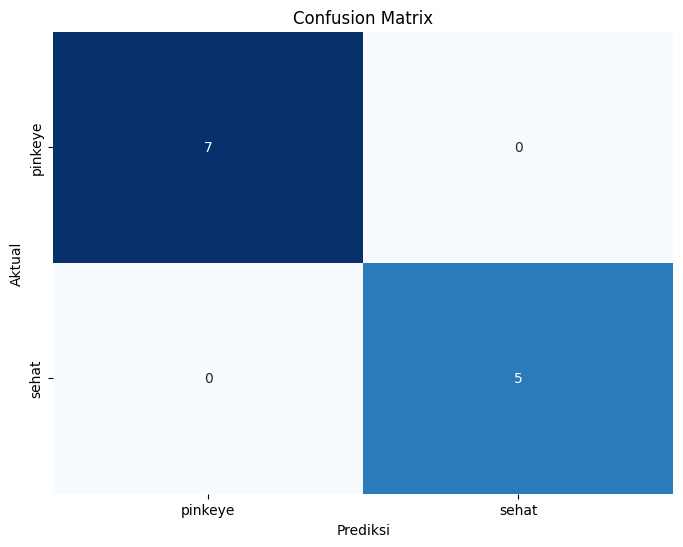

In [ ]:
cm = confusion_matrix(test_generator.classes, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['pinkeye', 'sehat'],
            yticklabels=['pinkeye', 'sehat'])
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

**Simpan Model**

In [ ]:
%cd /content/drive/MyDrive/pink eye goat classification

/content/drive/MyDrive/pink eye goat classification


In [ ]:
# Tentukan nama file untuk menyimpan model H5
model_filename = 'vgg16_transfer_dropout_model.h5'

# Simpan model ke dalam file H5
model.save(model_filename)

print(f"Model telah disimpan dalam file: {model_filename}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model telah disimpan dalam file: vgg16_transfer_dropout_model.h5


# Prediksi Gambar Baru

In [ ]:
from google.colab import files

# Upload gambar
uploaded = files.upload()

# Pastikan nama file gambar sesuai dengan yang diunggah
image_filename = list(uploaded.keys())[0]

Saving 4.jpg to 4.jpg


In [ ]:
from tensorflow.keras.models import load_model

# Tentukan nama file model H5 yang telah disimpan
model_filename = 'vgg16_transfer_dropout_model.h5'

# Memuat model
loaded_model = load_model(model_filename)


In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Membaca gambar yang diunggah
img = load_img(image_filename, target_size=(224, 224))
img_array = img_to_array(img)

# Menambahkan dimensi batch karena model mengharapkan input dalam bentuk batch
img_array = np.expand_dims(img_array, axis=0)

# Menampilkan gambar sebelum prediksi
plt.imshow(img)
plt.title('Input Image')
plt.axis('off')
plt.show()

# Memprediksi kelas gambar
predictions = loaded_model.predict(img_array)

# Mengambil indeks kelas dengan probabilitas tertinggi
predicted_class_index = np.argmax(predictions[0])

# Label mapping
class_mapping = {
    0: 'pink eye',
    1: 'sehat',
}

# Menampilkan hasil prediksi dengan label
predicted_class_label = class_mapping[predicted_class_index]

# Menampilkan hasil prediksi
print(f'Gambar {image_filename} diprediksi sebagai kelas: {predicted_class_label}')